In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.manifold import TSNE
from src import build_dataloader, build_model

In [2]:
train_loader, test_loader = build_dataloader(256)
model = build_model()
model.load_state_dict(torch.load("weight.pt"))
model.cuda()
model.eval();

### Sampling (from random noise)

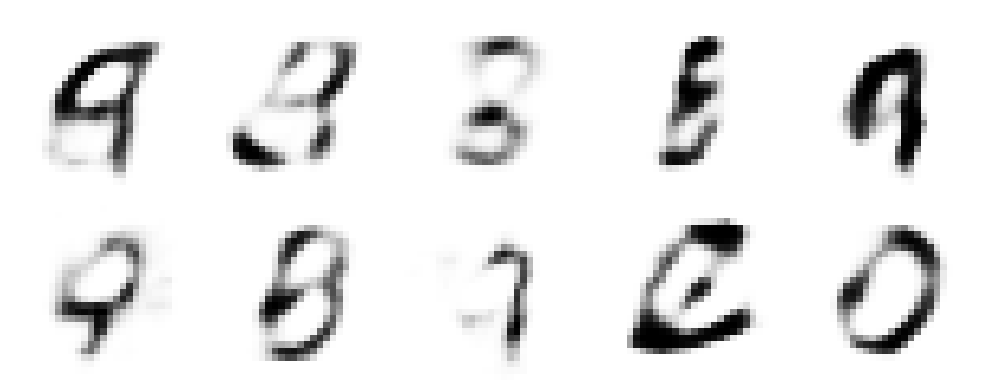

In [3]:
with torch.no_grad():
    z = torch.randn(10, 64, device = "cuda")
    samples = model.decode_image(z)
    samples = samples.reshape(-1, 1, 28, 28)[:, 0, :, :].cpu().numpy()

plt.figure(figsize = (10, 4))
for i, sample in enumerate(samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample, cmap = "binary")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Sampling (from a label)

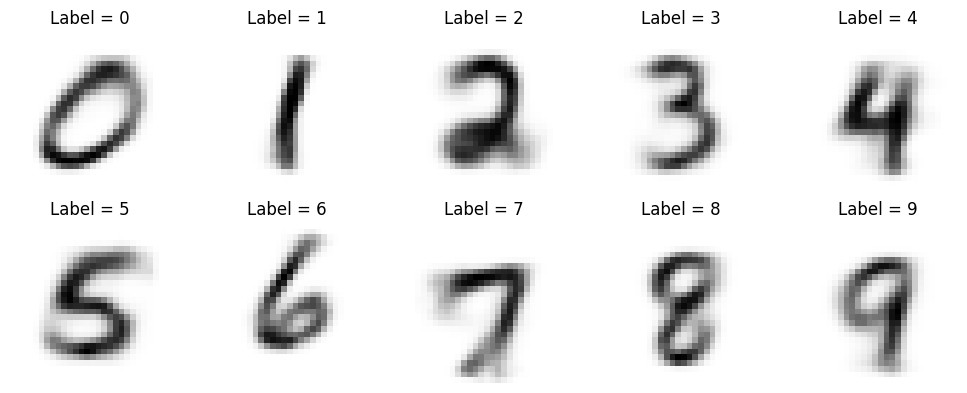

In [4]:
with torch.no_grad():
    labels = torch.arange(10, dtype = torch.long, device = "cuda")
    z = model.encode_label(labels)
    samples = model.decode_image(z)
    samples = samples.reshape(-1, 1, 28, 28)[:, 0, :, :].cpu().numpy()

plt.figure(figsize = (10, 4))
for i, sample in enumerate(samples):
    plt.subplot(2, 5, i + 1)
    plt.title(f"Label = {i}")
    plt.imshow(sample, cmap = "binary")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Clustering

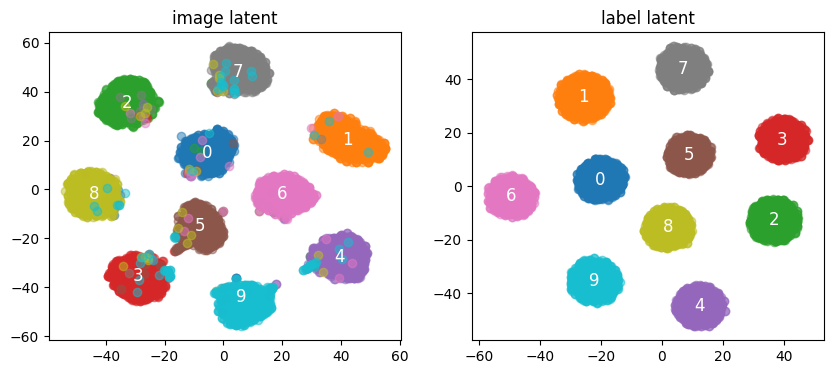

In [5]:
# get embedding
image_embed = []
label_embed = []
label_gt = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()

        i = model.encode_image(images.flatten(1))
        image_embed += i.cpu().tolist()

        l = model.encode_label(labels)
        label_embed += l.cpu().tolist()

        label_gt += labels.cpu().tolist()

image_embed = np.array(image_embed)
label_embed = np.array(label_embed)
label_gt = np.array(label_gt)

# run t-SNE
image_embed_2d = TSNE(n_components = 2).fit_transform(image_embed)
label_embed_2d = TSNE(n_components = 2).fit_transform(label_embed)

# plot
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.title("image latent")
for i in range(10):
    index = np.where(label_gt == i)
    x = image_embed_2d[index][:, 0]
    y = image_embed_2d[index][:, 1]
    plt.scatter(x, y, alpha = 0.5)
    plt.text(
        x = np.mean(x), 
        y = np.mean(y), 
        s = f"{i}", 
        fontsize = 12, 
        color = "w", 
        horizontalalignment = "center", 
        verticalalignment = "center"
    )

plt.subplot(1, 2, 2)
plt.title("label latent")
for i in range(10):
    index = np.where(label_gt == i)
    x = label_embed_2d[index][:, 0]
    y = label_embed_2d[index][:, 1]
    plt.scatter(x, y, alpha = 0.5)
    plt.text(
        x = np.mean(x), 
        y = np.mean(y), 
        s = f"{i}", 
        fontsize = 12, 
        color = "w", 
        horizontalalignment = "center", 
        verticalalignment = "center"
    )

plt.show()

### Interpolation

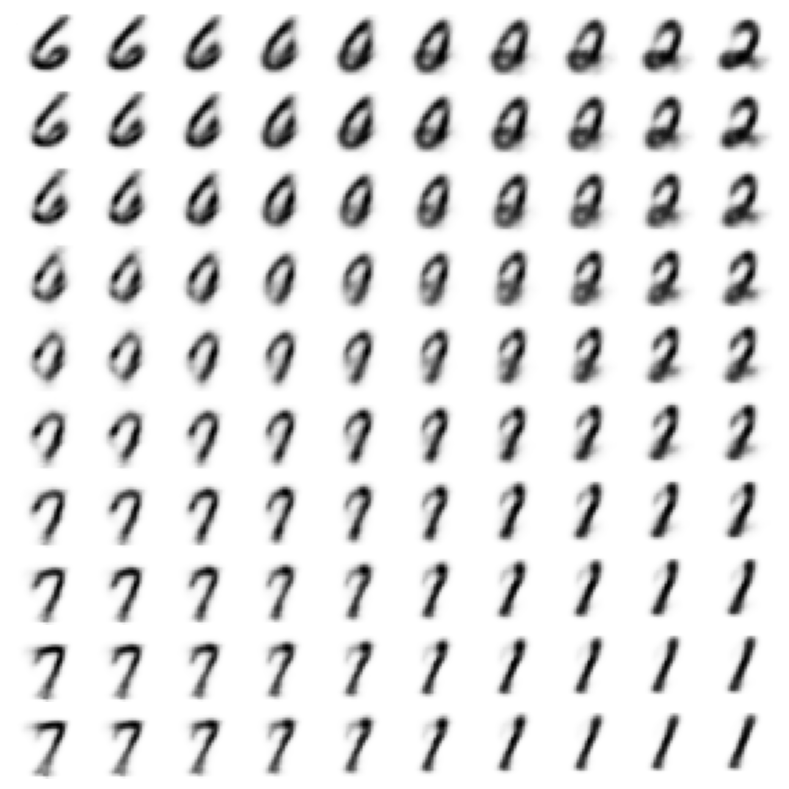

In [6]:
# set parameter
num = 10
label_m = 6
label_n = 2
label_p = 7
label_q = 1

# get weight
x = np.linspace(0, 1, num)
y = np.linspace(0, 1, num)
xx, yy = np.meshgrid(x, y)

w_m = np.clip(1 - (xx ** 2 + yy ** 2), 0, 1)
w_n = w_m[:, ::-1]
w_p = w_m[::-1, :]
w_q = w_m[::-1, ::-1]

weights = np.stack([w_m, w_n, w_p, w_q])
weights = weights / np.sum(weights, axis = 0)
weights = weights.transpose(1, 2, 0).reshape(-1, 4)

# interpolation
with torch.no_grad():
    labels = torch.arange(10, dtype = torch.long, device = "cuda")
    z = model.encode_label(labels)

    z_m = z[label_m]
    z_n = z[label_n]
    z_p = z[label_p]
    z_q = z[label_q]

    z = []
    for weight in weights:
        m, n, p, q = weight
        _z = m * z_m + n * z_n + p * z_p + q * z_q
        z.append(_z)
    z = torch.stack(z)

    samples = model.decode_image(z)
    samples = samples.reshape(-1, 1, 28, 28)[:, 0, :, :].cpu().numpy()

# plot
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols = (num, num), axes_pad = 0)
for ax, im in zip(grid, samples):
    ax.imshow(im, cmap = "binary")
    ax.axis("off")
plt.show()